### Langraph support external checkpointer databases to have long term memory of a chat

In [2]:
import sqlite3
# in memory
conn = sqlite3.connect(':memory:')

In [16]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)

In [3]:
# use local db
db_path = 'state_db/example.db'
conn = sqlite3.connect(db_path, check_same_thread=False)

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    summary: str

In [10]:
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage, RemoveMessage

def call_model(state: MessagesState):
    summary = state['summary']
    if summary:
        system_message = f'Summary of conversation earlier: {summary}'
        messages = [SystemMessage(content = system_message)] + state['messages']
    else:
        messages = state['messages']

    return {'messages': llm.invoke(messages)}

def summarize_conversation(state: MessagesState):
    summary = state['summary']
    if summary:
        summary_message = (
            f" This is the summary of the conversation to date: {summary}\n\n"
            " Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state['messages'] + [HumanMessage(content = summary_message)]
    response = llm.invoke(messages)

    # now we delete all but last 2 messages from our messages
    deleted_messages = [RemoveMessage(id = m.id) for m in state['messages'][: -3]]
    return {'summary': response.content, 'messages': deleted_messages}

In [12]:
from langgraph.graph import END

def should_continue(state: MessagesState):
    messages = state['messages']

    if len(messages) > 6:
        return 'summarize_conversation'

    return END



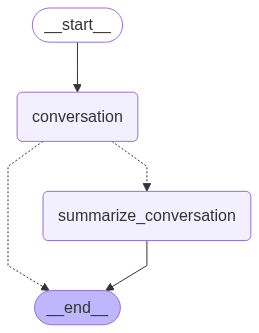

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(MessagesState)
workflow.add_node('conversation', call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, 'conversation')
workflow.add_conditional_edges('conversation',
  should_continue,
  path_map={'summarize_conversation': 'summarize_conversation', '__end__': '__end__'})
workflow.add_edge('summarize_conversation', END)

memory = MemorySaver()

graph = workflow.compile(checkpointer = memory)
graph

In [22]:
config = {'configurable': {'thread_id': 1}}
input_message = HumanMessage(content = 'Hi! I am Utkarsh')
output = graph.invoke({'messages': [input_message], 'summary': ''}, config)

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?
================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?


In [23]:
input_message = HumanMessage(content = 'What is my name?')
output = graph.invoke({'messages': [input_message], 'summary': ''}, config)

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?
================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Utkarsh.


In [24]:
input_message = HumanMessage(content = 'I like the 49ers')
output = graph.invoke({'messages': [input_message], 'summary': ''}, config)

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Your name is Utkarsh.
================================ Human Message =================================

I like the 49ers
================================== Ai Message ==================================

That's great! It's good to have a favorite team. What do you like about the 49ers? Are you excited about the upcoming season?
